## Einfaches Beispiel "Strom und Wärme"

Eine einfache Illustration, in der wir verschiedene Anlagen verbinden:
* KWK Anlage
* P2H (z.B. Wärmepumpe, Geothermie)
* Wärmespeicher

... plus (festem) Wärmebedarf und Strompreise

Das Wärmenetz besteht aus "Nord", "Süd" plus Verbindung


#### Ein paar Vorbereitungen in Python

In [1]:
import eaopack as eao
#####################################################
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

#### Definition der "Knoten", also der grundsätzlichen Struktur

Knoten bilden den virtuellen Punkt, in dem Wärme- und Stromanlagen angeschlossen sind. Die Knoten können durch "Transporte" verbunden werden

In [2]:
# Definition der phys. Einheiten
unit_power      = eao.assets.Unit(volume = 'MWh(el)', flow = 'MW(el)')
unit_heat       = eao.assets.Unit(volume = 'MWh(th)', flow = 'MW(th)')
# Definition der Knoten
node_power      = eao.assets.Node(name = 'strom'      , unit = unit_power)
node_heat_nord  = eao.assets.Node(name = 'waerme_nord', unit = unit_heat)
node_heat_sued  = eao.assets.Node(name = 'waerme_sued', unit = unit_heat)


#### Definition der einzelnen Anlagen und Verträge

Notiz: Wir vermeiden eine grundsätzliche Unterscheidung zwischen phys. Anlagen und Verträgen. Z.B. 
* der Wärmebedarf kann auch als zu erfüllender Absatzvertrag gesehen werden
* es könnten auch Strom-Terminverträge eingebunden werden (so physisch erfüllt)

In [3]:

# (1) Wärmespeicher
storage = eao.assets.Storage(name       = 'speicher', 
                            nodes       = node_heat_nord, 
                            cap_out     = .5, 
                            cap_in      = .5, 
                            size        = 3., 
                            start_level = 0.25, 
                            end_level   = 0.25,
                            eff_in      = 0.9, 
                            block_size  = 'd')     # Speicher soll täglich neu optimiert werden (nicht "leer hinterlassen")

# (2) Power to Heat Anlage (die Wärmepumpe). Hier vereinfacht abgebildet
#     Wir können zu einem gegebenen Wirkungsgrad "Strom in Wärme tauschen"
power2heat   = eao.assets.MultiCommodityContract(name = 'P2H',                           # Wärmepumpe (z.B. Geothermie)
                                                 min_cap = 0, 
                                                 max_cap = 2, 
                                                 nodes = [node_power, node_heat_nord],   # Lokalisierung: Knoten Nord für Wärme  -  plus Stromknoten
                                                 factors_commodities=[-1, 2])            # Wirkundsgrad: 1 MWh Strom zu 2 MWh Wärme

# (3) Kraft-Wärme-Kopplung (KWK). Hier als GuD abgebildet
#     Achtung - hier sind einige Parameter als Standardwerte gesetzt, die je nach Anwendungsfall angepasst werden sollten
KWK    = eao.assets.CHPAsset(name = "KWK", 
                                   min_cap     = 0, 
                                   max_cap     = 5,                             # max. Leistung Strom
                                   nodes       = [node_power, node_heat_sued],  # Erzeugung von Strom und Wärme in die entsprechenden Netze, bei Bedarf auch Gas
                                   start_costs = 0,                             # im Beispiel keine Startkosten
                                   extra_costs = 25,                            # Brennstoffkosten in €/MWh, natürlich auch als Zeitreihe möglich
                                   conversion_factor_power_heat=0.5,            # Verhältnis Produktion Wärme zu Strom 2:1, d.h. 1MW Stromverlust bei 2MW Wärmeproduktion
                                   max_share_heat = .5)                         # max. Anteil der Wärme an Gesamtproduktion (in MWh)
                                   ### ..viele weitere Parameter möglich, siehe Dokumentation. Z.B. Rampen, Mindestlaufzeiten, etc.

# (4) Wärmebedarf
#     Der Wärmebedarf muss immer gedeckt werden. Hier als "Contract" abgebildet; Maximum = Minimum bedeutet "keine Flexibilität"
bedarf_nord  = eao.assets.Contract(name = "bedarf_nord",  
                                   min_cap  = "waerme_bedarf_nord", # Referenziert auf Bezeichnung in Datenquelle
                                   max_cap  = "waerme_bedarf_nord", 
                                   nodes    = node_heat_nord)
bedarf_sued  = eao.assets.Contract(name     = "bedarf_sued",
                                   min_cap  = "waerme_bedarf_sued", 
                                   max_cap  = "waerme_bedarf_sued", 
                                   nodes = node_heat_sued)
# (5) Wärmeübertragungsnetz. Hier als "Transport" Asset abgebildet
#     Generell wird der Fluss immer in eine Richtung definiert. Daher im Beispiel 2 einzelne Richtungen Süd->Nord und Nord->Süd
netz_nord_sued  = eao.assets.Transport(name = 'netz_ns', 
                                       max_cap = 2,                 # max. Wärmeübertragungskapazität
                                       nodes = [node_heat_nord, node_heat_sued])
netz_sued_nord  = eao.assets.Transport(name = 'netz_sn', 
                                       max_cap = 1.5,
                                       nodes = [node_heat_sued, node_heat_nord])

# (3) Strommarkt
#     Wir können praktisch unbegrenzt Strom kaufen und verkaufen - zum vorgegebenen Preis
market       = eao.assets.SimpleContract(name = 'strommarkt', price='strompreis', min_cap= -1000, max_cap=1000, nodes = node_power)

#### Portfolio zusammensetzen
Die Anlagen und Verträge bilden die Details ab. Mit der Information zu den Knoten können sie einfach im Portfolio zusammengefasst werden
* Szenarioanalyse mit und ohne Anlagen
* auch viele Einzel-Portfolien möglich, falls nur Teile modelliert werden
* Teil-Portfolien können bei Bedarf als eine Anlage im Gesamtmodell zusammengefasst werden

In [4]:
portf        = eao.portfolio.Portfolio([storage, 
                                        power2heat, 
                                        KWK, 
                                        market, 
                                        bedarf_nord, 
                                        bedarf_sued, 
                                        netz_nord_sued, 
                                        netz_sued_nord])

#### Graphische Darstellung
Automatisch generiert. Im GUI kann die Darstellung angepasst werden.
* Gelb: Knoten
* Grau: Assets
* Pfeile: Anbindung der Assets an Knoten oder Transport

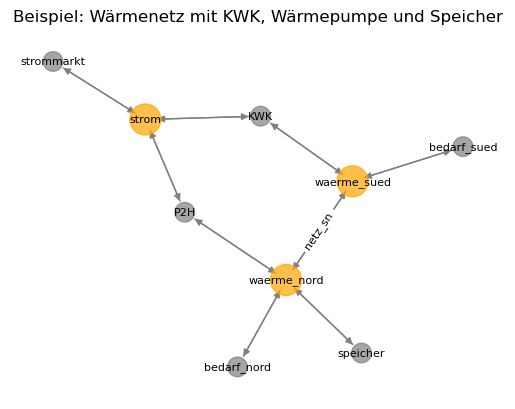

In [5]:
eao.network_graphs.create_graph(portf = portf, title = 'Beispiel: Wärmenetz mit KWK, Wärmepumpe und Speicher')

#### Randbemerkung
Das EAO ist so aufgesetzt, dass es einfach an eigene Datenbanken und Systeme angebunden werden kann.
Z.B. können alle Daten einfach in JSON exportiert (und eingelesen) werden. So auch im GUI

In [6]:
## in JSON File speichern zur weiteren Verwendung, z.B. in eigener Datenbank, dem GUI, etc. Genauso für Assets, etc.
eao.serialization.to_json(portf, 'portf.json')      # Gesamtbeispiel
eao.serialization.to_json(storage, 'speicher.json')
# ... etc. für alle Assets möglich'

#### Daten laden
Hier: Preise und Wärmebedarf aus Excel Datei laden

In [7]:
data = pd.read_excel("2020_sample_daten.xlsx")
data.set_index('datum', inplace=True)
data.round(2).head()

,strompreis,waerme_bedarf_nord,waerme_bedarf_sued
datum,,,
2020-01-01 00:00:00,41.88,-2.11,-0.31
2020-01-01 01:00:00,38.60,-2.17,-0.39
2020-01-01 02:00:00,36.55,-2.20,-0.49
2020-01-01 03:00:00,32.32,-2.20,-0.59
2020-01-01 04:00:00,30.85,-2.17,-0.70


#### Optimierung durchführen

In [8]:
Start = dt.date(2020,1,1)
End   = dt.date(2020,1,3)
tg    = eao.assets.Timegrid(Start, End, freq = 'h')     # hier: stündlich optimieren
out   = eao.optimize(portf = portf, timegrid = tg, data = data)
### Solver nach Geschmack leicht austauschbar. Z.B. Gurobi, CPLEX, freie Solver: SCIP, HIGHS ...
# out = eao.optimize(portf = portf, timegrid = tg, data = data, solver = 'SCIP')
### Split problem
out   = eao.optimize(portf = portf, timegrid = tg, data = data)
# out   = eao.optimize(portf = portf, timegrid = tg, data = data, split_interval_size='MS')

#### Randnotiz "Performance und Größenbeschränkung":

* MIP und LP: Kann das Portfolio als "LP" gelöst werden, ist die Rechenzeit deutlich schneller, als bei einem MIP. Hier kann über den Parameter "make_soft_problem" in der Optimierung gesteuert werden
* Solver sind nach Geschmack leicht austauschbar. Z.B. Gurobi, CPLEX, freie Solver: SCIP, HIGHS ...
* Generell erzeugen Speicher in der Optimierung leicht schwer lösbare Probleme. Hier empfehlen wir, die "block_size" z.B. auf täglich/wöchentlich zu setzen. So wird der Speicher nur über innerhalb jeden Tages / jeder Woche optimiert
* "Split Optimization": Für die meisten Probleme ist es eine gute Näherung, das Problem für jede Woche/ jeden Monat etc. zu lösen. In der entsprechenden Variante setzt EAO die Lösung automatisch zusammen. Randbedingungen wie Speicher Level oder Mindestmengen werden heruntergebrochen

#### Resultate analysieren
Vereinfachte Darstellung. Im Normalfall Export nach Excel oder in eine Schnittstelle in Datenbanken

In [9]:
out['summary'] # Zusammenfassung. Gesantwert in € (Deckungsbeitrag)

,Values
Parameter,
status,successful
value,1267.861623


In [10]:
out['DCF'].transpose().iloc[:,0:2].round(2) # Detailsicht auf die Cash Flows (auch diskontierte Optimierung möglich (DCF / Maximierung des NPV))

,2020-01-01 00:00:00,2020-01-01 01:00:00
speicher,0.00,0.00
P2H,0.00,0.00
KWK,-125.00,-125.00
strommarkt,164.02,143.65
bedarf_nord,0.00,0.00
bedarf_sued,0.00,0.00
netz_ns,0.00,0.00
netz_sn,0.00,0.00


In [11]:
# Detailsicht auf die Betriebsweise der Anlagen (in MWh)
print(out['dispatch'].transpose().iloc[:,0:2].round(2)) 

                           2020-01-01 00:00:00  2020-01-01 01:00:00
speicher (waerme_nord)                    0.25                 0.00
P2H (strom)                              -0.73                -0.90
P2H (waerme_nord)                         1.46                 1.80
KWK (strom)                               4.65                 4.62
KWK (waerme_sued)                         0.70                 0.76
strommarkt (strom)                       -3.92                -3.72
bedarf_nord (waerme_nord)                -2.11                -2.17
bedarf_sued (waerme_sued)                -0.31                -0.39
netz_ns (waerme_nord)                    -0.60                -0.61
netz_ns (waerme_sued)                     0.60                 0.61
netz_sn (waerme_sued)                    -0.99                -0.98
netz_sn (waerme_nord)                     0.99                 0.98


In [12]:
# Detailsicht auf die EIngangsgrößen (in €/MWh bzw. MW)  [hier vor Allem die vorgegebenen Preise, andere Analysen möglich --> Kosten für die Wärme pro Stunde]
out['prices'].transpose().iloc[:,0:2].round(2)

,2020-01-01 00:00:00,2020-01-01 01:00:00
nodal price: waerme_nord,20.94,19.30
nodal price: strom,41.88,38.60
nodal price: waerme_sued,20.94,19.30
input data: strompreis,41.88,38.60
input data: waerme_bedarf_nord,-2.11,-2.17
input data: waerme_bedarf_sued,-0.31,-0.39


#### Darstellung in Graphiken -- zur Diskussion

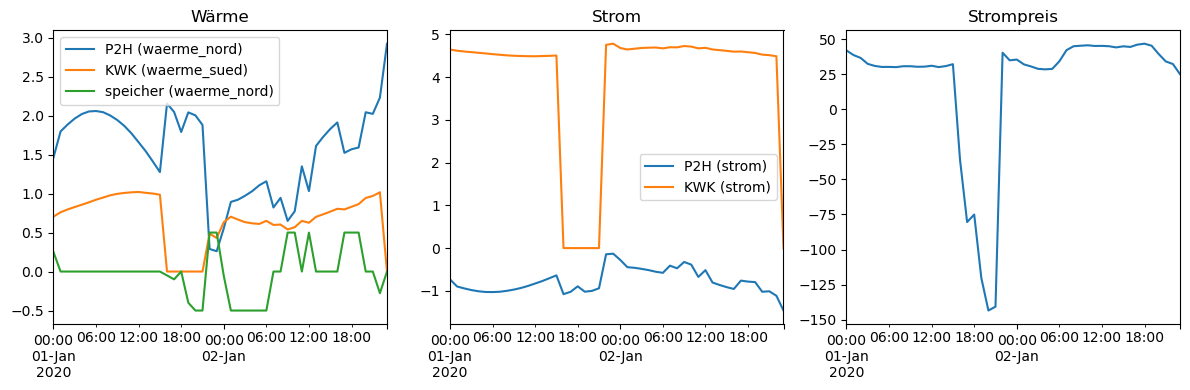

In [13]:
df = pd.merge(out['dispatch'], out['prices'], left_index=True, right_index=True, how='left')

heat = ['P2H (waerme_nord)',
        'KWK (waerme_sued)',
        'speicher (waerme_nord)']
power = ['P2H (strom)',
         'KWK (strom)']

fig, ax = plt.subplots(1,3, tight_layout = True, figsize=(12,4))
df[heat].plot(ax = ax[0], style = '-')
df[power].plot(ax = ax[1], style = '-')
df['input data: strompreis'].plot(ax = ax[2], style = '-')
ax[0].set_title('Wärme')
ax[1].set_title('Strom')
ax[2].set_title('Strompreis')
plt.show()
